In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import h5py,glob
import pandas as pd
import scipy
from scipy.optimize import curve_fit

### Beam measurements taken on the GBO Far Field Range

## Measurement List

Configuration 1: Bicolog + 2 inch post + 13 inch plate + drone mounted with bico SMA up
* E, H cuts in 400-800MHz with 50MHz steps
* E cuts for 400, 600, 800 repeated with configuration flipped 180 degrees
* E, H cross pol; E in 400-800 in 100MHz steps, H in 200MHz steps

Configuration 2: Passive HIRAX feed + 13 inch plate + drone mounted with petals AB up
* P1 E cut 400, 600, 800MHz
* P1 E crp 600 MHz


In [2]:
def get_rangedata(file):
    data = []
    with open(file, 'rt', encoding='utf8', errors='ignore') as csvfile:
            reader = csv.reader(csvfile, delimiter='\t')
            for row in reader:
                data.append(row)

    fileinfo = data[0:13]
    lowlim = float(data[6][0].split(':')[1])
    uplim = float(data[7][0].split(':')[1])
    
    phase = [float(data[13][i]) for i in np.arange(0,len(data[13]),2)]
    mags = [float(data[13][i]) for i in np.arange(1,len(data[13]),2)]
    angles = np.linspace(lowlim, uplim, len(mags))

    return(angles, phase, mags, fileinfo)
    
class rangedata:
    def __init__(self,file):
        data = get_rangedata(file)
        self.angles = data[0]
        self.phase = data[1]
        self.amplitude = data[2]
        self.offset = float(data[3][-2][0].split(':')[1])
        self.fileinfo = data[3]
    

# Config 1: Drone + Bicolog

In [3]:
data = {}

files='/hirax/rf_data/GBO_range_data/config1*'
fileset= np.sort(glob.glob(files))

for file in fileset:
    config = file.split('.ATR')[0].split('/')[-1]
    data[config] = rangedata(file)

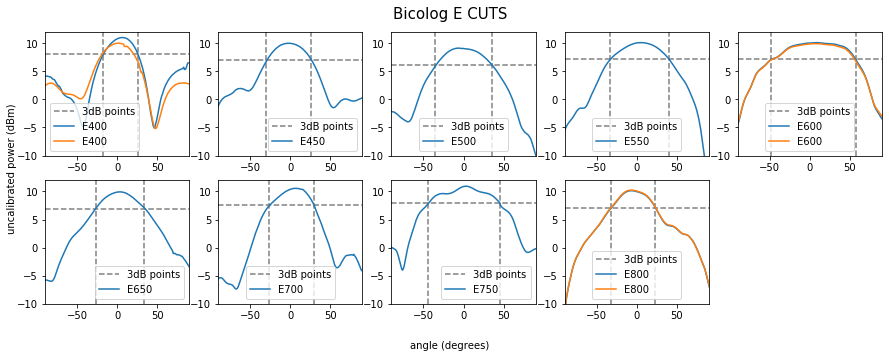

Text(0.5, 0.95, 'Bicolog H CUTS')

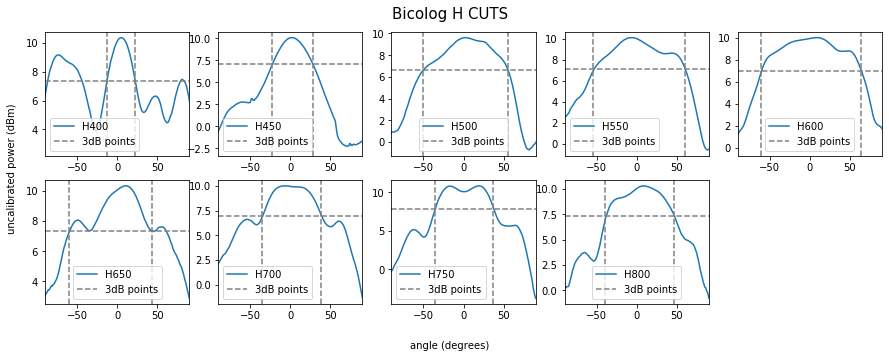

In [4]:
fig = plt.figure(figsize = (15,5))
counter = 1

for freq in np.arange(400,850,50):
    ax = fig.add_subplot(2,5,counter)
    for key in data.keys():
        j = 0
        if str(freq) in key and 'E' in key and 'CR' not in key and 'fl' not in key:
            if '0_' not in key: 
                threedb = np.max(np.array(data[key].amplitude))-3
                ax.axhline(threedb, color = 'gray', linestyle = '--', label = '3dB points')
                indx = np.argwhere(np.diff(np.sign(np.array(data[key].amplitude) - threedb))).flatten()
                
                for i in indx: 
                    ax.axvline(data[key].angles[i], color = 'gray', linestyle = '--')

            ax.plot(data[key].angles, np.array(data[key].amplitude), label = key.split('_')[1])
    
    
    ax.legend()
    ax.set_xlim(-90,90)
    ax.set_ylim(-10,12)
    counter +=1 

fig.text(0.5, 0, 'angle (degrees)', ha='center')
fig.text(0.09, 0.5, 'uncalibrated power (dBm)', va='center', rotation='vertical')    
plt.suptitle('Bicolog E CUTS', fontsize = 15, y = 0.95)
plt.show()


fig = plt.figure(figsize = (15,5))
counter = 1

for freq in np.arange(400,850,50):
    ax = fig.add_subplot(2,5,counter)
    for key in data.keys():
        if str(freq) in key and 'H' in key and 'CR' not in key and 'cr' not in key:
            ax.plot(data[key].angles, np.array(data[key].amplitude), label = key.split('_')[1])
    
            threedb = np.max(np.array(data[key].amplitude))-3
            ax.axhline(threedb, color = 'gray', linestyle = '--', label = '3dB points')
            indx = np.argwhere(np.diff(np.sign(np.array(data[key].amplitude) - threedb))).flatten()
            
            indx0 = len(data[key].amplitude)/2
            inxdiff = [(indx-indx0)[i] for i in range(len(indx))]
            toplotmin = [(indx-indx0)[i] for i in range(len(indx)) if (indx-indx0)[i] < 0]
            toplotmax = [(indx-indx0)[i] for i in range(len(indx)) if (indx-indx0)[i] > 0]

            for i in [indx[inxdiff.index(toplotmin[-1])], indx[inxdiff.index(toplotmax[0])]]:
                ax.axvline(data[key].angles[i], color = 'gray', linestyle = '--')

    ax.legend()
    ax.set_xlim(-90,90)
    counter +=1 
fig.text(0.5, 0, 'angle (degrees)', ha='center')
fig.text(0.09, 0.5, 'uncalibrated power (dBm)', va='center', rotation='vertical')    
plt.suptitle('Bicolog H CUTS', fontsize = 15, y = 0.95)


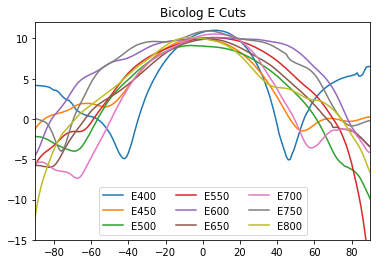

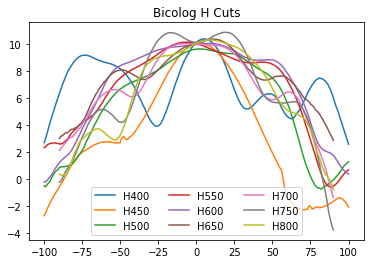

In [5]:
for freq in np.arange(400,850,50):
    for key in data.keys():
        if str(freq) in key and 'E' in key and 'CR' not in key \
        and 'cr' not in key and '0_' not in key and 'flip' not in key:
            plt.plot(data[key].angles, np.array(data[key].amplitude), label = key.split('_')[1])
plt.legend(ncol = 3)
plt.xlim(-90,90)
plt.ylim(-15,12)
plt.title('Bicolog E Cuts')
plt.show()

for freq in np.arange(400,850,50):
    for key in data.keys():
        if str(freq) in key and 'H' in key and 'CR' not in key and 'cr' not in key:
            plt.plot(data[key].angles, np.array(data[key].amplitude), label = key.split('_')[1])
plt.legend(ncol = 3, loc = 'lower center')
plt.title('Bicolog H Cuts')
plt.show()



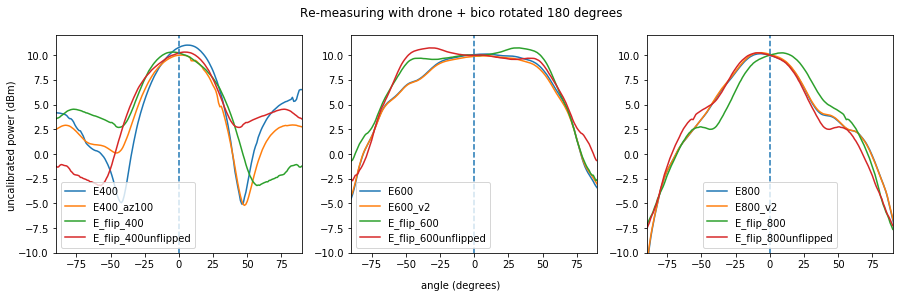

In [6]:
#Q: are features range or feed?

fig = plt.figure(figsize = (15,4))
counter = 1

for freq in [400, 600, 800]:
    ax = fig.add_subplot(1,3,counter)
    for key in data.keys():
        if str(freq) in key and 'E' in key and 'CR' not in key:
            plt.plot(data[key].angles, np.array(data[key].amplitude), label = key.split('config1_')[1])
        if str(freq) in key and 'E_f' in key:
            plt.plot(data[key].angles[::-1], np.array(data[key].amplitude), label = key.split('config1_')[1]+str('unflipped'))

    ax.legend()
    ax.set_xlim(-90,90)
    ax.set_ylim(-10,12)
    ax.axvline(0, linestyle = '--')
    counter +=1 
fig.text(0.5, 0, 'angle (degrees)', ha='center')
fig.text(0.08, 0.5, 'uncalibrated power (dBm)', va='center', rotation='vertical')    
plt.suptitle('Re-measuring with drone + bico rotated 180 degrees')
plt.show()

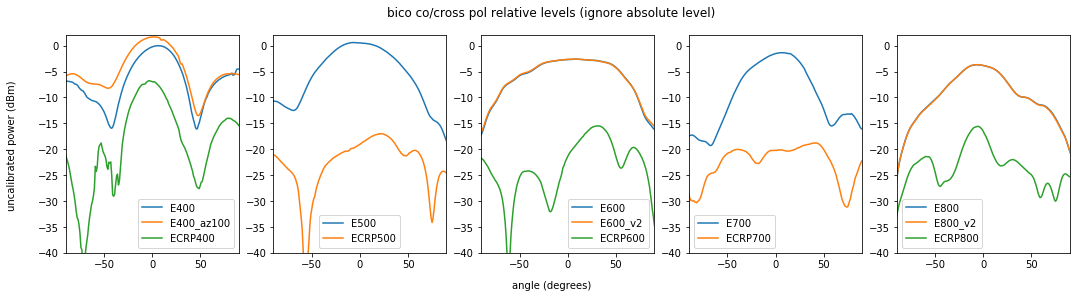

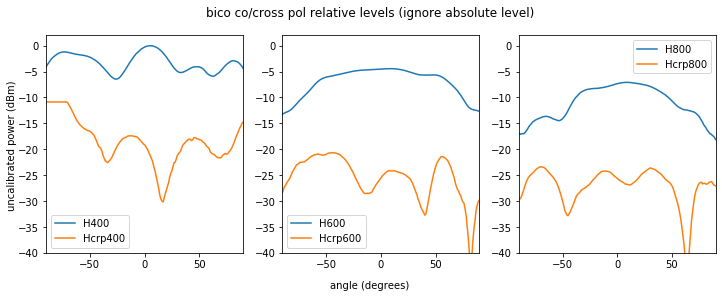

In [7]:
fig = plt.figure(figsize = (18,4))
counter = 1

for freq in np.arange(400,900,100):
    ax = fig.add_subplot(1,5,counter)
    for key in data.keys():
        if str(freq) in key and 'E' in key and ('CR' in key or 'cr' in key):
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_E400'].amplitude)-data['config1_E400'].offset).max(), label = key.split('config1_')[1])
        if str(freq) in key and 'E' in key and 'CR' not in key and 'cr' not in key and 'fl' not in key:
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_E400'].amplitude)-data['config1_E400'].offset).max(), label = key.split('config1_')[1])

    ax.legend()
    ax.set_xlim(-90,90)
    ax.set_ylim(-40,2)
    counter +=1 
fig.text(0.5, 0, 'angle (degrees)', ha='center')
fig.text(0.08, 0.5, 'uncalibrated power (dBm)', va='center', rotation='vertical')    
plt.suptitle('bico co/cross pol relative levels (ignore absolute level)')
plt.show()



fig = plt.figure(figsize = (12,4))
counter = 1

for freq in [400, 600, 800]:
    ax = fig.add_subplot(1,3,counter)
    for key in data.keys():
        if str(freq) in key and 'H' in key and ('CR' in key or 'cr' in key):
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_H400'].amplitude)-data['config1_H400'].offset).max(), label = key.split('config1_')[1])
        if str(freq) in key and 'H' in key and 'CR' not in key and 'cr' not in key and 'fl' not in key:
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_H400'].amplitude)-data['config1_H400'].offset).max(), label = key.split('config1_')[1])

    ax.legend()
    ax.set_xlim(-90,90)
    ax.set_ylim(-40,2)
    counter +=1 
fig.text(0.5, 0, 'angle (degrees)', ha='center')
fig.text(0.08, 0.5, 'uncalibrated power (dBm)', va='center', rotation='vertical')    
plt.suptitle('bico co/cross pol relative levels (ignore absolute level)')
plt.show()



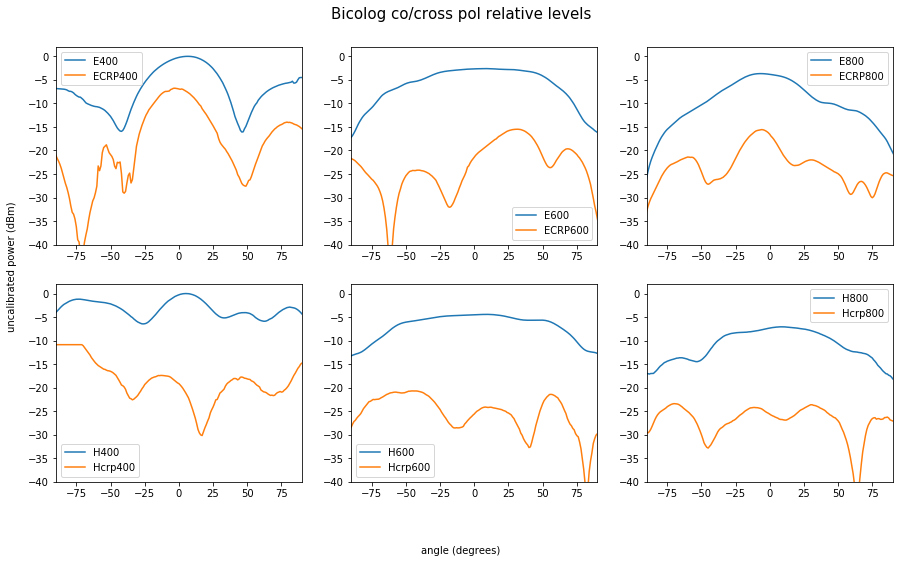

 (ignore absolute level, maybe even relative levels lol.....)


In [8]:
fig = plt.figure(figsize = (15,8))
counter = 1

for freq in [400, 600, 800]:
    ax = fig.add_subplot(2,3,counter)
    for key in data.keys():
        if str(freq) in key and 'E' in key and ('CR' in key or 'cr' in key):
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_E400'].amplitude)-data['config1_E400'].offset).max(), label = key.split('config1_')[1])
        if str(freq) in key and 'E' in key and 'CR' not in key and 'cr' not in key and 'fl' not in key and '0_' not in key:
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_E400'].amplitude)-data['config1_E400'].offset).max(), label = key.split('config1_')[1])

    ax.legend()
    ax.set_xlim(-90,90)
    ax.set_ylim(-40,2)
    counter +=1 

for freq in [400, 600, 800]:
    ax = fig.add_subplot(2,3,counter)
    for key in data.keys():
        if str(freq) in key and 'H' in key and ('CR' in key or 'cr' in key):
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_H400'].amplitude)-data['config1_H400'].offset).max(), label = key.split('config1_')[1])
        if str(freq) in key and 'H' in key and 'CR' not in key and 'cr' not in key and 'fl' not in key:
            plt.plot(data[key].angles, np.array(data[key].amplitude)-data[key].offset-(np.array(data['config1_H400'].amplitude)-data['config1_H400'].offset).max(), label = key.split('config1_')[1])

    ax.legend()
    ax.set_xlim(-90,90)
    ax.set_ylim(-40,2)
    counter +=1 
fig.text(0.5, 0, 'angle (degrees)', ha='center')
fig.text(0.08, 0.5, 'uncalibrated power (dBm)', va='center', rotation='vertical')    
plt.suptitle('Bicolog co/cross pol relative levels', fontsize = 15, y = 0.95)
plt.show()

print(' (ignore absolute level, maybe even relative levels lol.....)')


# Config 2: Drone + HIRAX Feed

In [9]:
data2 = {}

fileset='/hirax/rf_data/GBO_range_data/config2*'
allscans= np.sort(glob.glob(fileset))

for file in allscans:
    config = file.split('.ATR')[0].split('/')[-1]
    data2[config] = rangedata(file)

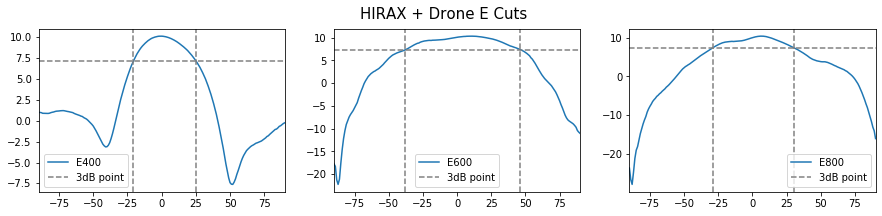

In [10]:
fig = plt.figure(figsize = (15,3))
counter = 1

for freq in [400, 600,800]:
    ax = fig.add_subplot(1,3,counter)
    for key in data2.keys():
        if str(freq) in key and 'E' in key and 'cr' not in key:
            plt.plot(data2[key].angles, np.array(data2[key].amplitude), label = key.split('_')[1])
            
            
            threedb = np.max(np.array(data2[key].amplitude))-3
            ax.axhline(threedb, color = 'gray', linestyle = '--', label = '3dB point')
            indx = np.argwhere(np.diff(np.sign(np.array(data2[key].amplitude) - threedb))).flatten()
                
            for i in indx: 
                ax.axvline(data2[key].angles[i], color = 'gray', linestyle = '--')

    
    ax.legend()
    ax.set_xlim(-90,90)
    counter +=1 
plt.suptitle('HIRAX + Drone E Cuts', fontsize= 15)
plt.show()


(-90, 90)

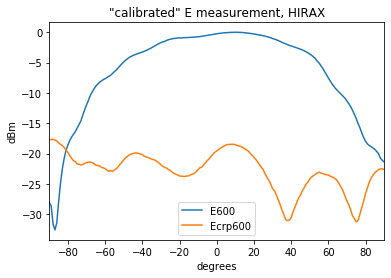

In [11]:
hirax600max = np.max(np.array(data2['config2_E600'].amplitude)-data2['config2_E600'].offset)

for key in data2.keys():
    if '600' in key:
        plt.plot(data2[key].angles, np.array(data2[key].amplitude)-data2[key].offset - hirax600max, label = key.split('_')[1])

plt.legend()
plt.title('"calibrated" E measurement, HIRAX')
plt.xlabel('degrees')
plt.ylabel('dBm')
plt.xlim(-90,90)
# plt.ylim(-20,3)